In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
# using SharedArrays

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [3]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [5]:
#
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset,
             U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.2, 2.2, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

In [6]:
# scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [7]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = vcat(blobs₊, blobs₋)

# data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/example2/data/data_vortex.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-2.018587306805637, 0.3469573514039377, 0.45880001794294045, -1.8218225076346501, 1.8957320291019035, 0.3768744289098014, -1.8102180547912552, 1.0615219698346763, 0.26918155979815017, -1.273480600181778, 1.3996292681183138, 0.39099049767578464, -1.3586001809001103, 0.7834839950529129, 0.2327616928563841], [-2.018587306805637 -2.0172169502893196 … 12.59044061465947 12.591482987090947; 0.3469573514039377 0.3469042736866317 … 1.1421505993204804 1.1421716017979275; … ; 0.7834839950529129 0.7835958875071971 … 1.5055566951364918 1.5054079889283538; 0.2327616928563841 0.2327616928563841 … 0.2327616928563841 0.2327616928563841], [-0.524522656873511 -0.5090575008179341 … -0.4727590518054783 -0.4724508529842126; -0.5379397508961893 -0.5208171476572888 … -0.5119750022574816 -0.51414802719

In [8]:
# scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

In [9]:
# heatmap(data.yt)

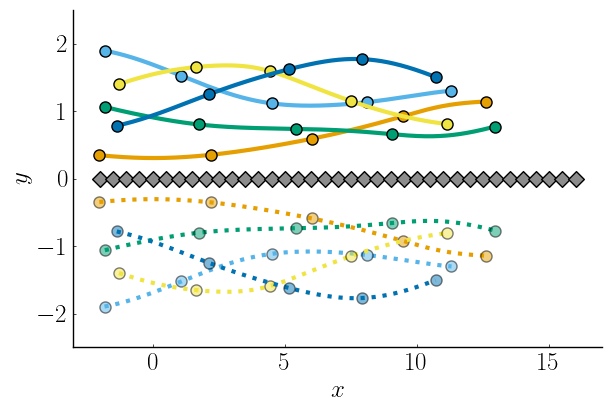

In [10]:
plt = plot(xlim = (-3, 17), ylim = (-2.5, 2.5), xlabel = L"x", ylabel = L"y", fontsize = 18)
scatter!(plt, real.(sensors), imag.(sensors), color = :gray55, markersize = 8, legend = false, 
         markershape = :diamond)

c_list = palette(:okabe_ito)
tsnap = collect(0.0:3.0:12.0)
for i=1:config_data.Nv
    plot!(plt, data.xt[3*(i-1)+1,:], data.xt[3*(i-1)+2,:], linewidth = 3, color = c_list[i])
    plot!(plt, data.xt[3*(i-1)+1,:], -data.xt[3*(i-1)+2,:], linewidth = 3, color = c_list[i], linestyle = :dot)
    
    for (j, tj) in enumerate(tsnap)
        nj = ceil(Int64, tj/config_data.Δt)+1
    if mod(nj-1, 2)==0
        scatter!(plt, [data.xt[3*(i-1)+1,nj]], [data.xt[3*(i-1)+2,nj]], markersize = 8, color = c_list[i])
        scatter!(plt, [data.xt[3*(i-1)+1,nj]], [-data.xt[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = c_list[i])

            #     elseif mod(j, 2)==1
#         scatter!(plt, [data.xt[3*(i-1)+1,nj]], [data.xt[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = color_palette[i])
    end
    end
    
end
plt

savefig("setup_example2.pdf")

In [36]:
Xflowrank, Xalowrank = load("/media/mat/HDD/LowRankVortex.jl/example2/ensemble_lowrank_99_Ne_"*string(50)*"_3.jld", "Xf", "Xa");

In [19]:
Xflowrank, Xalowrank = load("/media/mat/HDD/LowRankVortex.jl/example2/ensemble_Ne_"*string(50)*"_2.jld", "Xf", "Xa");

In [37]:
q5 = zero(data.xt)
q10 = zero(data.xt)
q25 = zero(data.xt)
q50 = zero(data.xt)
q75 = zero(data.xt)
q90 = zero(data.xt)
q95 = zero(data.xt)

for i=1:length(data.tt)
    for j=1:size(data.xt,1)
    q5[j,i] = quantile(Xalowrank[i][j,:], 0.05)
    q10[j,i] = quantile(Xalowrank[i][j,:], 0.10)
    q25[j,i] = quantile(Xalowrank[i][j,:], 0.25)
    q50[j,i] = quantile(Xalowrank[i][j,:], 0.50)
    q75[j,i] = quantile(Xalowrank[i][j,:], 0.75)
    q90[j,i] = quantile(Xalowrank[i][j,:], 0.90)
    q95[j,i] = quantile(Xalowrank[i][j,:], 0.95)
    end
end

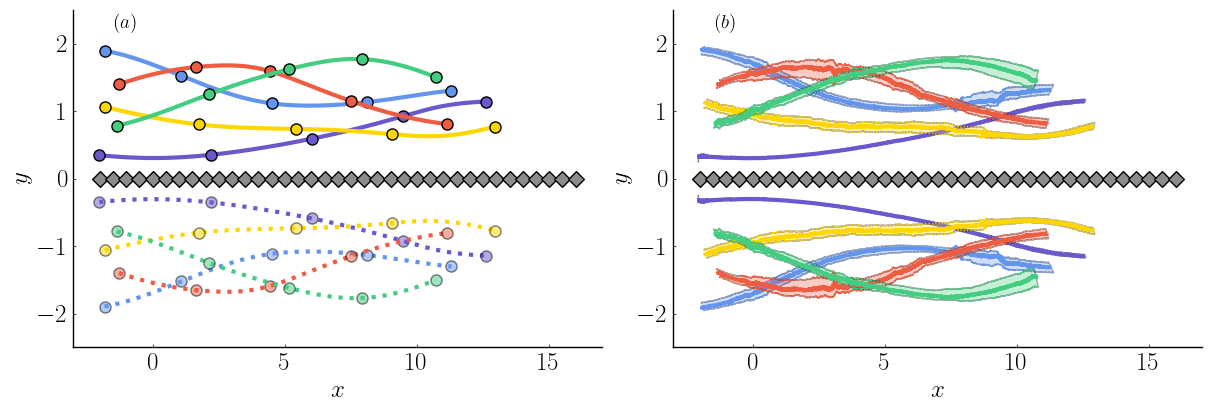

In [71]:
plt = plot(layout = grid(1,2), xlabel = L"x", ylabel = L"y", fontsize = 18)# size = (800, 500))

plot!(plt[1,1], size = (1200, 400), xlim = (-3, 17), ylim = (-2.5, 2.5))
scatter!(plt, real.(sensors), imag.(sensors), color = :gray55, markersize = 8, legend = false, 
         markershape = :diamond)

# c_list = palette(:okabe_ito)
c_list = [colorant"slateblue3";
          colorant"cornflowerblue";
          colorant"gold";
          colorant"tomato2";
          colorant"seagreen3"]

tsnap = collect(0.0:3.0:12.0)
for i=1:config_data.Nv
    plot!(plt[1,1], data.xt[3*(i-1)+1,:], data.xt[3*(i-1)+2,:], linewidth = 3, color = c_list[i])
    plot!(plt[1,1], data.xt[3*(i-1)+1,:], -data.xt[3*(i-1)+2,:], linewidth = 3, color = c_list[i], linestyle = :dot)
    
    for (j, tj) in enumerate(tsnap)
        nj = ceil(Int64, tj/config_data.Δt)+1
    if mod(nj-1, 2)==0
        scatter!(plt[1,1], [data.xt[3*(i-1)+1,nj]], [data.xt[3*(i-1)+2,nj]], markersize = 8, color = c_list[i])
        scatter!(plt[1,1], [data.xt[3*(i-1)+1,nj]], [-data.xt[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = c_list[i])

            #     elseif mod(j, 2)==1
#         scatter!(plt, [data.xt[3*(i-1)+1,nj]], [data.xt[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = color_palette[i])
    end
    end
    
end

annotate!(plt[1,1], -1.0, 2.3, L"(a)", fontsize = 18)
annotate!(plt[1,2], -1.0, 2.3, L"(b)", fontsize = 18)

plot!(plt[1,2], xlim = (-3, 17), ylim = (-2.5, 2.5))
scatter!(plt[1,2], real.(sensors), imag.(sensors), color = :gray55, markersize = 8, legend = false, 
         markershape = :diamond)

# c_list = palette(:okabe_ito)
tsnap = collect(0.0:3.0:12.0)
alphavalue = 0.5

for i=1:config_data.Nv
    

    plot!(plt[1,2], [Shape(vcat(q5[3*(i-1)+1,:], reverse(q95[3*(i-1)+1,:])), 
          vcat(q5[3*(i-1)+2,:], reverse(q95[3*(i-1)+2,:])))], color = c_list[i], alpha = 0.3)
    plot!(plt[1,2], q5[3*(i-1)+1,:], q5[3*(i-1)+2,:], linewidth = 1, linestyle = :dot, 
        color = c_list[i])
#     plot!(plt[1,2], q95[3*(i-1)+1,:], q95[3*(i-1)+2,:], linewidth = 1, linestyle = :dot,
#           fillrange = [q5[3*(i-1)+2,:]],
#         color = c_list[i], alpha = 0.5)

    plot!(plt[1,2], q95[3*(i-1)+1,:], q95[3*(i-1)+2,:], linewidth = 1, linestyle = :dot, 
          color = c_list[i])
    plot!(plt[1,2], q50[3*(i-1)+1,:], q50[3*(i-1)+2,:], linewidth = 3, linestyle = :solid, 
          color = c_list[i])
#     plot!(plt[1,2], data.xt[3*(i-1)+1,:], data.xt[3*(i-1)+2,:], linewidth = 3, 
#           color = c_list[i], linestyle = :solid)
    plot!(plt[1,2], [Shape(vcat(q5[3*(i-1)+1,:], reverse(q95[3*(i-1)+1,:])), 
          vcat(-q5[3*(i-1)+2,:], reverse(-q95[3*(i-1)+2,:])))], color = c_list[i], alpha = 0.3)
    plot!(plt[1,2], q5[3*(i-1)+1,:], -q5[3*(i-1)+2,:], linewidth = 1, linestyle = :dot, 
          color = c_list[i])
#     plot!(plt[1,2], q95[3*(i-1)+1,:], -q95[3*(i-1)+2,:], linewidth = 1, linestyle = :dot,
#           fillrange = [-q5[3*(i-1)+2,:]],
#         color = c_list[i], alpha = 0.5)
    plot!(plt[1,2], q95[3*(i-1)+1,:], -q95[3*(i-1)+2,:], linewidth = 1, linestyle = :dot, 
          color = c_list[i])
    plot!(plt[1,2], q50[3*(i-1)+1,:], -q50[3*(i-1)+2,:], linewidth = 3, linestyle = :solid, 
          color = c_list[i])
#     plot!(plt[1,2], data.xt[3*(i-1)+1,:], -data.xt[3*(i-1)+2,:], linewidth = 3, 
#           color = c_list[i], linestyle = :solid)
#           linestyle = :dash, linewidth = 3, color = c_list[i], alpha = 0.5)

    for (j, tj) in enumerate(tsnap)
        nj = ceil(Int64, tj/config_data.Δt)+1
        if mod(nj-1, 2)==0
#             scatter!(plt, [mean_hist(Xalowrank)[3*(i-1)+1,nj]], [mean_hist(Xalowrank)[3*(i-1)+2,nj]], markersize = 8, color = c_list[i])
#             scatter!(plt, [mean_hist(Xalowrank)[3*(i-1)+1,nj]], [-mean_hist(Xalowrank)[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = c_list[i])

            #     elseif mod(j, 2)==1
#         scatter!(plt, [data.xt[3*(i-1)+1,nj]], [data.xt[3*(i-1)+2,nj]], alpha = 0.5, markersize = 8, color = color_palette[i])
    end
    end
    
end
plt

savefig("setup_example2.pdf")